In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/FA-KES/FA-KES-Dataset.csv'

df = pd.read_csv(path, encoding= 'unicode_escape')
df.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [2]:
print(df.shape)
df.isna().sum()

(804, 7)


unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64

,new,labels
0,Car bomb attack kills at least 26 in Syria war...,1
1,35 Dead Dozens Wounded in Terrorist Battle in ...,1
2,Syrian Army Kills over 80 Terrorists in Variou...,0
3,Suicide bomber kills six in Syria restaurant R...,1
4,School bombing kills 30 children in Syria moni...,0
...,...,...
799,Hundreds dead as fresh airstrikes hit Syrias A...,1
800,Aleppos Civilian Massacre Continues 88 Killed ...,1
801,Syrian Army Kills over 70 ISIL Terrorists in A...,0
802,Deadly Russian Airstrikes Kill 35 & Destroy Ho...,1


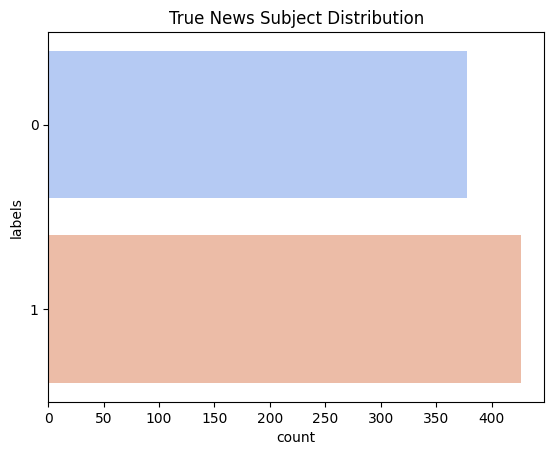

In [3]:
from sklearn.utils import shuffle

df['new'] = df['article_title'] + ' ' + df['article_content']

df = df[['new','labels']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="labels", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   new     804 non-null    object
 1   labels  804 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB


In [5]:
df.drop_duplicates(subset=['new'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 803
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   new     790 non-null    object
 1   labels  790 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.5+ KB


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['new'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [8]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 790
Max length of the titles: 887
Mean length of the titles: 202.71772151898733
Median length of the titles: 175.0


In [9]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(df['new'])

sequences = tokenizer.texts_to_sequences(df['new'])
padded_df = pad_sequences(sequences,maxlen = 500, padding = 'pre', truncating = 'post')


# **LSTM**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.01
optimizer = Adam(lr=0.01)
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=500))
model.add(Dropout(0.3))
# model.add(LSTM(50, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg),return_sequences=True))
model.add(Bidirectional(LSTM(50, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg))))
# model.add(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['labels'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


Epoch 1/10
9/9 [==============================] - 12s 322ms/step - loss: 2.7597 - accuracy: 0.5190 - val_loss: 1.7712 - val_accuracy: 0.4937
Epoch 2/10
9/9 [==============================] - 1s 63ms/step - loss: 1.5783 - accuracy: 0.5371 - val_loss: 1.4596 - val_accuracy: 0.4937
Epoch 3/10
9/9 [==============================] - 1s 63ms/step - loss: 1.3586 - accuracy: 0.6094 - val_loss: 1.3533 - val_accuracy: 0.5570
Epoch 4/10
9/9 [==============================] - 1s 121ms/step - loss: 1.0625 - accuracy: 0.8156 - val_loss: 1.3530 - val_accuracy: 0.4557
Epoch 5/10
9/9 [==============================] - 1s 89ms/step - loss: 0.7941 - accuracy: 0.8788 - val_loss: 1.6937 - val_accuracy: 0.4684
Epoch 6/10
9/9 [==============================] - 1s 102ms/step - loss: 0.6338 - accuracy: 0.9222 - val_loss: 1.3814 - val_accuracy: 0.4810
Epoch 7/10
9/9 [==============================] - 1s 93ms/step - loss: 0.5108 - accuracy: 0.9331 - val_loss: 1.4780 - val_accuracy: 0.5570
Epoch 8/10
9/9 [=======

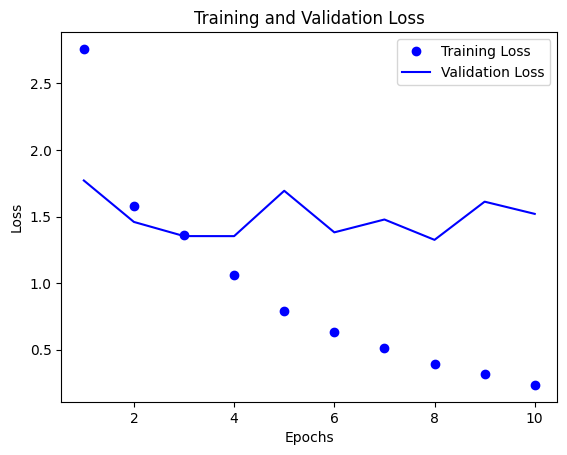

In [12]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 10)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5/5 [==============================] - 1s 24ms/step
BiLSTM Model Accuracy :  0.4873417721518987
Precision :  0.5054945054945055
Recall :  0.5609756097560976
F1 :  0.5317919075144509
G-mean: 0.4783502887176958
Training time:  19.486652374267578
Inference time:  0.9869487285614014
              precision    recall  f1-score   support

           0       0.46      0.41      0.43        76
           1       0.51      0.56      0.53        82

    accuracy                           0.49       158
   macro avg       0.48      0.48      0.48       158
weighted avg       0.48      0.49      0.48       158



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


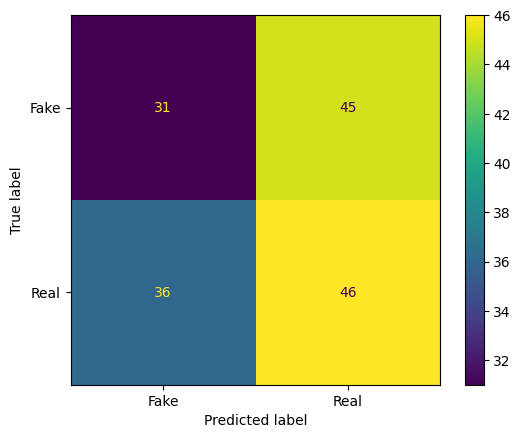

In [13]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("BiLSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()